In [1]:
pip install torch botorch gpytorch scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.6/629.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [38]:
import numpy as np
import pandas as pd
import torch
from botorch.models import FixedNoiseGP, SingleTaskGP, HeteroskedasticSingleTaskGP
from gpytorch.kernels import ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from scipy.stats import norm
from botorch.acquisition.analytic import ExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound, PosteriorMean
import matplotlib.pyplot as plt
import sys
import time
import os
from torch.optim import Adam
import gpytorch
import seaborn as sns
from ipywidgets import Output, HBox
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
import math

In [15]:
data=pd.read_csv('MOF_data.csv')

In [24]:
df_al = data.dropna()
df_al = df_al[df_al['del_q'] >= 0]
df_al = df_al.drop('Pu',axis=1).reset_index(drop=True) # contains 0 only
df_al.drop(columns=["uptake_ads","uptake_des","del_q","heat_ads","heat_des","del_H_ads"],inplace=True) # for removing them from features
df_al = df_al.sample(frac=1).reset_index(drop=True)

**Query Function(It will take labelled and unlabelled data and will prompt the user for next COP, till it converges)**

In [49]:
def bayesian_optimization_function(number_of_iterations, number_of_initial_samples, labelled_data, unlabelled_data, model_type="SingleTaskGP", observation_noise=1e-5):
    assert number_of_iterations <= len(unlabelled_data)

    # Column of MOF names
    MOF_name = unlabelled_data["MOF"].values

    labelled_data = labelled_data.drop(columns="MOF")
    X_labelled = labelled_data.drop(columns="COP").values#extracting features of labelled data
    y_labelled = labelled_data["COP"].values

    # Extracting features of unlabelled data
    unlabelled_data = unlabelled_data.drop(columns="MOF")
    X_unlabelled = unlabelled_data.values

    scaler = StandardScaler()
    X_labelled = scaler.fit_transform(X_labelled)
    X_unlabelled = scaler.transform(X_unlabelled)

    # Two empty lists to store the maximum COP observed so far and the COP values at each iteration
    max_cop_observed = []
    cop_at_iteration = []

    # Converting the numpy arrays to PyTorch tensors
    X_labelled_tensor = torch.tensor(X_labelled, dtype=torch.float32)
    X_unlabelled_tensor = torch.tensor(X_unlabelled, dtype=torch.float32)
    y_labelled_tensor = torch.tensor(y_labelled, dtype=torch.float32)

    # Use this model if there is noise in the data
    if model_type == "HeteroskedasticSingleTaskGP":
        observation_noise_tensor = torch.full_like(y_labelled_tensor, observation_noise)

    y_initial = y_labelled_tensor.unsqueeze(1)#Reshaping the y_initial
    x_initial = X_labelled_tensor

    for i in range(number_of_iterations):
        # Initialization of GP model
        if model_type == "SingleTaskGP":
            model = SingleTaskGP(x_initial, y_initial)
        elif model_type == "HeteroskedasticSingleTaskGP":
            model = HeteroskedasticSingleTaskGP(x_initial, y_initial, observation_noise_tensor)

        # Creating MLL object for model's likelihood and fitting by maximizing the MLL
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        # if max_cop_observed is empty, appends the maximum value from y_initial
        if not max_cop_observed:
            max_cop_observed.append(y_initial.max().item())

        '''
        posterior_mean = PosteriorMean(model)
        with torch.no_grad():
            posterior_means = posterior_mean(X_unlabelled_tensor.unsqueeze(1)).squeeze()
        best_f = posterior_means.max().item()'''
        '''
        EI = ExpectedImprovement(model, best_f=y_initial.max().item())
        with torch.no_grad():
            ei_values = EI(X_unlabelled_tensor.unsqueeze(1))

        next_point_idx = ei_values.argmax().item()
        next_point = X_unlabelled_tensor[next_point_idx]
        next_mof_name = MOF_name[next_point_idx]'''

        # UCB acquisition function
        ucb = UpperConfidenceBound(model, beta=4*np.exp(-0.05*i))
        with torch.no_grad():
            ucb_values = ucb(X_unlabelled_tensor.unsqueeze(1))

        # Identifies index based on highest ucb values
        next_point_idx = ucb_values.argmax().item()
        next_point = X_unlabelled_tensor[next_point_idx]
        next_mof_name = MOF_name[next_point_idx]

        # Prompts the user to enter COP value of selected MOF
        new_cop_value = float(input(f"Enter the COP value for {next_mof_name}:"))

        # Updates y_initial and x_initial by concatenating the new data point and its corresponding COP value
        y_initial = torch.cat([y_initial, torch.tensor([new_cop_value], dtype=torch.float32).unsqueeze(1)], dim=0)
        x_initial = torch.cat([x_initial, next_point.unsqueeze(0)], dim=0)

        # If the model is heteroskedastic, updates the observation noise tensor with the new noise value
        if model_type == "HeteroskedasticSingleTaskGP":
            observation_noise_tensor = torch.cat([observation_noise_tensor, torch.tensor([observation_noise], dtype=torch.float32)])

        # Updates the max_cop_observed and cop_at_iteration lists with the new COP values
        curr_max_cop = max(max_cop_observed) if max_cop_observed else new_cop_value
        max_cop_observed.append(max(curr_max_cop, new_cop_value))
        cop_at_iteration.append(new_cop_value)

        # Creates new row with selected unlabelled data point and appends it in dataframe
        new_row = pd.DataFrame([next_point.numpy()], columns=labelled_data.columns[:-1])
        new_row['COP'] = new_cop_value
        labelled_data = pd.concat([labelled_data, new_row], ignore_index=True)

        # Plotting
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        # Maximum COP Observed plot
        plt.subplot(1, 2, 1)
        plt.plot(range(len(max_cop_observed)), max_cop_observed, marker='o', linestyle='-', color='b')
        plt.title('Maximum COP Observed')
        plt.xlabel('Iteration')
        plt.ylabel('COP')

        # COP at Each Iteration plot
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1, len(cop_at_iteration) + 1), cop_at_iteration, marker='x', linestyle='--', color='r')
        plt.title('COP at Each Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('COP')

        plt.tight_layout()
        plt.show()

        # Remove the selected MOF from the unlabelled data
        X_unlabelled_tensor = torch.cat([X_unlabelled_tensor[:next_point_idx], X_unlabelled_tensor[next_point_idx+1:]])
        MOF_name = np.delete(MOF_name, next_point_idx)

    csv_file_name = "updated_labelled_data.csv"
    labelled_data.to_csv(csv_file_name, index=False)
    return csv_file_name

In [1]:
number_of_initial_samples = 10
number_of_iterations = 200
labelled_data = df_al.sample(number_of_initial_samples)
unlabelled_data = df_al.drop(labelled_data.index)
unlabelled_data = unlabelled_data.drop(columns="COP")
bayesian_optimization_function(number_of_iterations, number_of_initial_samples, labelled_data, unlabelled_data)

NameError: name 'df_al' is not defined

In [17]:
df_al

,MOF,LISD,LFSD,LISFS,Unit_cell_volume,Density,ASA_A2,ASA_m2_per_cm3,ASA_m2_per_g,NASA_A2,...,La,Cr,Ti,Ba,Rh,Ce,Cu,Al,Re,COP
0,XUKYEI_neutral,13.18217,10.20370,13.18217,6140.000,0.287208,1122.8100,1828.680,6367.080,0.0000,...,0,0,0,0,0,0,2,0,0,0.583945
1,ja300034j_si_002_clean,17.49700,17.44104,17.49700,2800.680,0.713223,390.5410,1394.450,1955.140,0.0000,...,0,0,0,0,0,0,0,0,0,0.542431
2,QIYDAF01_clean,22.00141,13.48659,22.00141,52812.600,0.303251,8995.1500,1703.220,5616.540,0.0000,...,0,0,0,0,0,0,24,0,0,0.522907
3,XAHPIH_clean,14.37026,13.22660,14.37026,12821.800,0.356183,2130.4900,1661.620,4665.070,0.0000,...,0,0,0,0,0,0,8,0,0,0.515395
4,VETMIS_clean,18.13430,11.96931,18.13430,33152.200,0.311959,5856.6500,1766.600,5662.900,0.0000,...,0,0,0,0,0,0,12,0,0,0.512710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,SANHUN_clean,6.56302,4.77517,6.56302,3664.890,1.599000,394.0410,1075.180,672.406,0.0000,...,0,0,0,0,0,0,0,0,0,0.000327
6913,PEKVUY_clean,5.67220,3.42753,4.50995,1630.010,2.827110,75.6807,464.295,164.230,67.0363,...,0,0,0,2,0,0,0,0,0,0.000246
6914,HEXNII_clean,4.90669,3.50214,4.90669,847.141,1.567280,37.4215,441.738,281.850,0.0000,...,0,0,0,0,0,0,0,0,0,0.000137
6915,IBIYUO_clean,5.16636,4.13343,5.13222,17478.700,2.019600,806.0660,461.169,228.346,0.0000,...,0,0,0,0,0,0,64,0,0,0.000066


In [47]:
# This function is created only for checking the query function which was above
def bayesian_optimization_function_helper(number_of_iterations, number_of_initial_samples, labelled_data, unlabelled_data, cop_data, model_type="SingleTaskGP", observation_noise=1e-5):
    assert number_of_iterations <= len(unlabelled_data)
    MOF_name = unlabelled_data["MOF"].values

    labelled_data = labelled_data.drop(columns="MOF")
    X_labelled = labelled_data.drop(columns="COP").values
    y_labelled = labelled_data["COP"].values

    unlabelled_data = unlabelled_data.drop(columns="MOF")
    X_unlabelled = unlabelled_data.values

    scaler = StandardScaler()
    X_labelled = scaler.fit_transform(X_labelled)
    X_unlabelled = scaler.transform(X_unlabelled)

    max_cop_observed = []
    cop_at_iteration = []

    X_labelled_tensor = torch.tensor(X_labelled, dtype=torch.float32)
    X_unlabelled_tensor = torch.tensor(X_unlabelled, dtype=torch.float32)
    y_labelled_tensor = torch.tensor(y_labelled, dtype=torch.float32)

    if model_type == "HeteroskedasticSingleTaskGP":
        observation_noise_tensor = torch.full_like(y_labelled_tensor, observation_noise)

    y_initial = y_labelled_tensor.unsqueeze(1)
    x_initial = X_labelled_tensor

    for i in range(number_of_iterations):
        if model_type == "SingleTaskGP":
            model = SingleTaskGP(x_initial, y_initial)
        elif model_type == "HeteroskedasticSingleTaskGP":
            model = HeteroskedasticSingleTaskGP(x_initial, y_initial, observation_noise_tensor)

        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        if not max_cop_observed:
            max_cop_observed.append(y_initial.max().item())

        '''
        EI = ExpectedImprovement(model, best_f=best_f)
        with torch.no_grad():
            ei_values = EI(X_unlabelled_tensor.unsqueeze(1))

        next_point_idx = ei_values.argmax().item()
        next_point = X_unlabelled_tensor[next_point_idx]
        next_mof_name = MOF_name[next_point_idx]'''

        # Use UCB instead of EI
        ucb = UpperConfidenceBound(model, beta=6*np.exp(-0.05*i))  # Adjust beta as needed
        with torch.no_grad():
            ucb_values = ucb(X_unlabelled_tensor.unsqueeze(1))

        next_point_idx = ucb_values.argmax().item()
        next_point = X_unlabelled_tensor[next_point_idx]
        next_mof_name = MOF_name[next_point_idx]

        # Fetch COP value from the provided cop_data dataframe
        new_cop_value = cop_data.loc[cop_data['MOF'] == next_mof_name, 'COP'].values[0]

        y_initial = torch.cat([y_initial, torch.tensor([new_cop_value], dtype=torch.float32).unsqueeze(1)], dim=0)
        x_initial = torch.cat([x_initial, next_point.unsqueeze(0)], dim=0)

        if model_type == "HeteroskedasticSingleTaskGP":
            observation_noise_tensor = torch.cat([observation_noise_tensor, torch.tensor([observation_noise], dtype=torch.float32)])

        curr_max_cop = max(max_cop_observed) if max_cop_observed else new_cop_value
        max_cop_observed.append(max(curr_max_cop, new_cop_value))
        cop_at_iteration.append(new_cop_value)

        new_row = pd.DataFrame([next_point.numpy()], columns=labelled_data.columns[:-1])
        new_row['COP'] = new_cop_value
        labelled_data = pd.concat([labelled_data, new_row], ignore_index=True)

        # Plotting
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        # Maximum COP Observed plot
        plt.subplot(1, 2, 1)
        plt.plot(range(len(max_cop_observed)), max_cop_observed, marker='o', linestyle='-', color='b')
        plt.title('Maximum COP Observed')
        plt.xlabel('Iteration')
        plt.ylabel('COP')

        # COP at Each Iteration plot
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1, len(cop_at_iteration) + 1), cop_at_iteration, marker='x', linestyle='--', color='r')
        plt.title('COP at Each Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('COP')

        plt.tight_layout()
        plt.show()

        # Remove the selected MOF from the unlabelled data
        X_unlabelled_tensor = torch.cat([X_unlabelled_tensor[:next_point_idx], X_unlabelled_tensor[next_point_idx+1:]])
        MOF_name = np.delete(MOF_name, next_point_idx)

    csv_file_name = "updated_labelled_data.csv"
    labelled_data.to_csv(csv_file_name, index=False)
    return csv_file_name

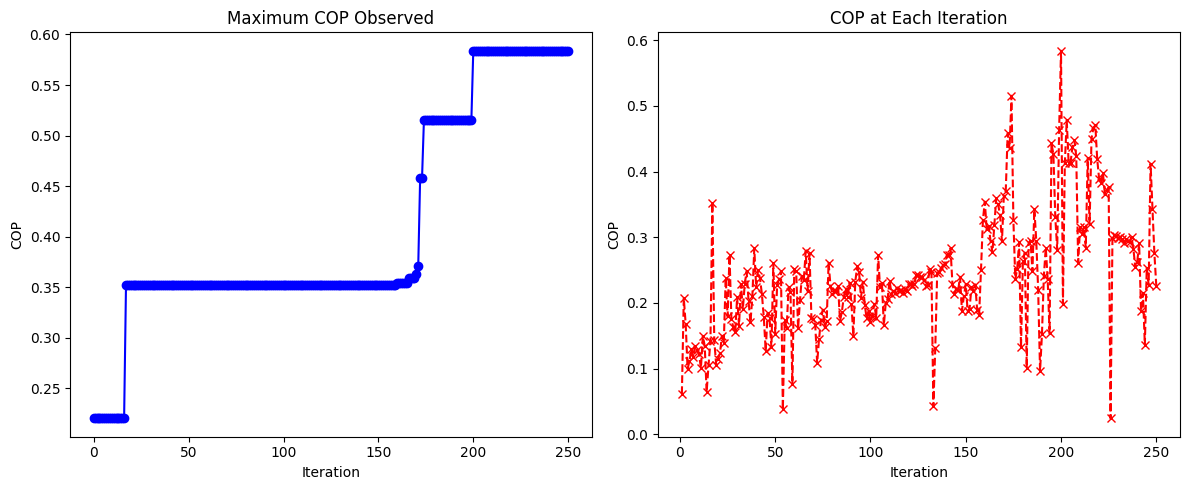

'updated_labelled_data.csv'

In [48]:
number_of_initial_samples = 10
number_of_iterations = 250
labelled_data = df_al.sample(number_of_initial_samples)
unlabelled_data = df_al.drop(labelled_data.index)
cop_data=unlabelled_data[["MOF","COP"]]
unlabelled_data = unlabelled_data.drop(columns="COP")
bayesian_optimization_function_helper(number_of_iterations, number_of_initial_samples, labelled_data, unlabelled_data,cop_data)

In [28]:
 cop_data

,MOF,COP
0,BAEDTA01_clean,0.042531
1,IWEWIS_clean,0.037963
2,UMODEH08_clean,0.189146
3,YEMLUY_charged,0.024235
4,IFENOY02_SL,0.008981
...,...,...
6912,cm503311x_alf200K_clean,0.051202
6913,OWIJAH_clean,0.065223
6914,MATPUV_clean,0.069110
6915,OHEMIX_clean,0.250770
